#### Date created: 8/10/204 <br>
#### Purpose: To compute and visualize analytic exoplanet orbits, given a snapshot of their orbital properties from the NASA Exoplanet Archive.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from astropy.time import Time
from astropy.constants import G
from astropy.constants import M_sun
import astropy.units as u
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from geopy import geocoders  
from geopy.geocoders import Nominatim
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from exo_horoscope import main
from main import User
import warnings

In [2]:
exoplanets_table = NasaExoplanetArchive.query_criteria(table="pscomppars", select="*")

In [3]:
print(exoplanets_table.colnames)

['pl_name', 'pl_letter', 'hostname', 'hd_name', 'hip_name', 'tic_id', 'disc_pubdate', 'disc_year', 'discoverymethod', 'disc_locale', 'disc_facility', 'disc_instrument', 'disc_telescope', 'disc_refname', 'ra', 'rastr', 'dec', 'decstr', 'glon', 'glat', 'elon', 'elat', 'ra_reflink', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbperstr', 'pl_orbper_reflink', 'pl_orblpererr1', 'pl_orblper', 'pl_orblpererr2', 'pl_orblperlim', 'pl_orblperstr', 'pl_orblper_reflink', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_orbsmaxstr', 'pl_orbsmax_reflink', 'pl_angsep', 'pl_angseperr1', 'pl_angseperr2', 'pl_angseplim', 'pl_angsepstr', 'pl_angsep_reflink', 'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_orbincllim', 'pl_orbinclstr', 'pl_orbincl_reflink', 'pl_orbtper', 'pl_orbtpererr1', 'pl_orbtpererr2', 'pl_orbtperlim', 'pl_orbtperstr', 'pl_orbtper_reflink', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_orbeccenstr', 'pl_or

In [12]:
exoplanets_table[0]

pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,disc_facility,disc_instrument,disc_telescope,disc_refname,ra,rastr,dec,decstr,glon,glat,elon,elat,ra_reflink,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbperstr,pl_orbper_reflink,pl_orblpererr1,pl_orblper,pl_orblpererr2,pl_orblperlim,pl_orblperstr,pl_orblper_reflink,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxstr,pl_orbsmax_reflink,pl_angsep,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepstr,pl_angsep_reflink,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbinclstr,pl_orbincl_reflink,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtperstr,pl_orbtper_reflink,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenstr,pl_orbeccen_reflink,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqtstr,pl_eqt_reflink,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdepstr,pl_occdep_reflink,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insolstr,pl_insol_reflink,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densstr,pl_dens_reflink,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandepstr,pl_trandep_reflink,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmidstr,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pmdecstr,sy_plx,sy_plxerr1,sy_plxerr2,sy_plxstr,sy_plx_reflink,sy_dist,sy_disterr1,sy_disterr2,sy_diststr,sy_dist_reflink,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmagstr,sy_bmag_reflink,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmagstr,sy_vmag_reflink,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_jmag_reflink,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_hmag_reflink,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_kmagstr,sy_kmag_reflink,sy_umag,sy_umagerr1,sy_umagerr2,sy_umagstr,sy_umag_reflink,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_rmagstr,sy_rmag_reflink,sy_imag,sy_imagerr1,sy_imagerr2,sy_imagstr,sy_imag_reflink,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_zmagstr,sy_zmag_reflink,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1magstr,sy_w1mag_reflink,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2magstr,sy_w2mag_reflink,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3magstr,sy_w3mag_reflink,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4magstr,sy_w4mag_reflink,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_gmagstr,sy_gmag_reflink,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamagstr,sy_gaiamag_reflink,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmagstr,sy_tmag_reflink,pl_controv_flag,pl_orbtper_systemref,pl_tranmid_systemref,st_metratio,st_spectype,st_spectype_reflink,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmagstr,sy_kepmag_reflink,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_rotpstr,st_rotp_reflink,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_projobliqstr,pl_projobliq_reflink,gaia_id,cb_flag,pl_tranmid_reflink,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandurstr,pl_trandur_reflink,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvampstr,pl_rvamp_reflink,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radjstr,pl_radj_reflink,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radestr,pl_rade_reflink,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_ratrorstr,pl_ratror_reflink,pl_ratdor,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,pl_trueobliqstr,pl_trueobliq_reflink,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmagstr,sy_icmag_reflink,dkin_flag,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratdorstr,pl_ratdor_reflink,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_impparstr,pl_imppar_reflink,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassjstr,pl_bmassj_reflink,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassestr,pl_bmasse_reflink,pl_bmassprov,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffstr,st_teff_reflink,st_met,st_meterr1,st_meterr2,st_metlim,st_metstr,st_met_reflink,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radvstr,st_radv_reflink,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_vsinstr,st_vsin_reflink,st_lum,st_lumerr1,st_lumerr2,st_lumlim,s

In [8]:
def kepler_orbit_deriv(state, a, e, M_star):
    """
    Compute derivatives for the orbital integration.
    
    Parameters:
    - state: Current state of the system [r, dr/dt]; r is the distance from the star and dr/dt is the velocity we can use this proxy pl_rvamp in m/s
    - a: pl_orbsmax Semi-major axis in units of (AU)
    - e: pl_orbeccen Eccentricity
    - M_star: st_mass Mass of the host star in units of (solar masses)
    
    Returns:
    - Derivatives [dr/dt, d^2r/dt^2]
    """
    r, drdt = state #r can be initialized with the semi-major axis
    mu = G * M_star  # Gravitational parameter
    
    # Compute d^2r/dt^2 using the gravitational force equation
    d2rdt2 = -mu / r**2
    
    return [drdt, d2rdt2]

In [11]:
def integrate_orbit(a, e, i, Omega, omega, M0, t0, t_end, M_star, num_points=1000):
    """
    Integrate the orbit and return position arrays.
    
    Parameters:
    - a: pl_orbsmax Semi-major axis in units of (AU)
    - e: pl_orbeccen Eccentricity 
    - i: pl_orbincl Inclination in units of (degrees)
    - Omega: pl_longasc Longitude of the ascending node in units of (degrees) (the angle from the vernal equinox to the ascending node of the planet's orbit)
    - omega: pl_orblper: Argument of periapsis in units of (degrees) ((the angle between the direction of the ascending node and the periastron))
    - M0: pl_orbtper: Time of periapsis passage, which can be related to Mean Anomaly at reference time in units of (radians)
    - t0: Reference time (datetime) This could be any arbitrary point in time or the date when observations were made.
    - t_end: End time for integration (datetime) orbital_period = np.nanmean(np.asarray(closest_table["pl_orbtper"].value)) t_end = t0 + orbital_period
    - M_star: st_mass Mass of the host star in units of (solar masses)
    - num_points: Number of points in the orbit
    
    Returns:
    - x, y, z: Position arrays (AU)
    """
    # Convert times to Julian Dates for easier manipulation
    t0_jd = Time(t0).jd
    t_end_jd = Time(t_end).jd

    # Time grid
    t = np.linspace(t0_jd, t_end_jd, num_points)

    # Convert all parameters to the appropriate units
    a_value = a.to(u.m).value  # Convert AU to meters
    e_value = e.value
    i_value = i.to(u.rad).value  # Convert degrees to radians
    Omega_value = Omega.to(u.rad).value  # Convert degrees to radians
    omega_value = omega.to(u.rad).value  # Convert degrees to radians
    M0_value = M0.to(u.rad).value  # Convert degrees to radians if needed
    M_star_value = M_star.to(u.kg).value  # Convert solar masses to kilograms

    # Initial state
    r0 = a_value * (1 - e_value)  # periapsis distance as initial distance
    drdt0 = np.sqrt(G.value * M_star_value / r0)  # initial radial velocity (simplified)
    initial_state = [r0, drdt0]

    # Define the derivative function for orbit integration
    def kepler_orbit_deriv(state, t, a, e, M_star):
        r, drdt = state
        # Define the derivative of the orbit here
        # Example: drdt is the derivative of r with respect to time
        # Placeholder implementation for kepler_orbit_deriv
        return [drdt, -G.value * M_star / r**2]

    # Integrate the orbit
    state = odeint(kepler_orbit_deriv, initial_state, t, args=(a_value, e_value, M_star_value))

    r = state[:, 0]
    drdt = state[:, 1]

    # Compute x, y, z coordinates
    x = r * (np.cos(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) - np.sin(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
    y = r * (np.sin(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) + np.cos(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
    z = r * (np.sin(omega_value + np.arctan2(drdt, r)) * np.sin(i_value))

    return x, y, z

In [12]:
a = 1.0 * u.AU
e = 0.1 * u.dimensionless_unscaled
i = 0.0 * u.deg
Omega = 0.0 * u.deg
omega = 0.0 * u.deg
M0 = 0.0 * u.rad
t0 = datetime(2020, 1, 1)
t_end = datetime(2024, 8, 8)
M_star = 1.0 * M_sun

In [13]:
x, y, z = integrate_orbit(a, e, i, Omega, omega, M0, t0, t_end, M_star)

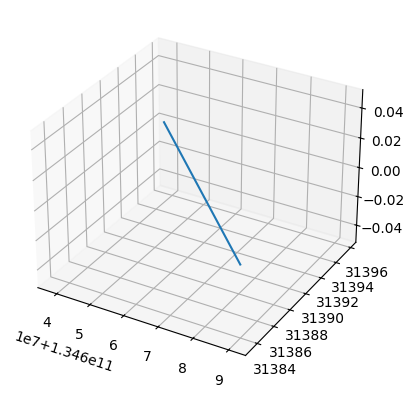

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
plt.show()

## Use on realistic orbit from nearest-to-zenith transiting birth exoplanet

In [20]:
import importlib.resources
import os
from astropy.io import ascii
with importlib.resources.path('exo_horoscope', 'main.py') as package_root_path:
    package_root = package_root_path.parent

catalog_path = os.path.join(package_root, 'confirmed_exoplanets_table_orbital_params.ecsv')

with importlib.resources.path('exo_horoscope', 'confirmed_exoplanets_table_orbital_params.ecsv') as catalog_path:
    exoplanets_table = ascii.read(catalog_path)

In [11]:
test = User("Someone", "Copenhagen Denmark", 1997, 11, 1, 23, 0, 0)

In [12]:
test.get_closest_table()

ra,dec,pl_name,hostname,pl_orbeccen,pl_orbsmax,pl_orbper,st_mass,pl_bmassj,pl_radj,pl_dens,pl_eqt,st_rad,st_teff,sy_gaiamag
deg,deg,,,,AU,d,solMass,jupiterMass,jupiterRad,g / cm3,K,solRad,K,mag
float64,float64,str29,str27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.3691648,56.025708,GPX-1 b,GPX-1,0.0,0.0338,1.744579,1.68,19.7,1.47,8.222423,2300.0,1.56,7000.0,12.2228


In [26]:
class Orbit_Integration(object):
    """
    Orbit integration class
    """

    def __init__(self, user, citystate, year, month, day, hour, minute, second):
        """
        Args:
            user (str): User's name in the form 'User'
            citystate (str): City and State of birth in the form: 'City State' / 'City Country'
            year (int): Birthyear of User
            month (int): Birthmonth of User
            day (int): Birthday of User
            hour (int): Birthhour of User
            minute (int): Birthminute of User
            second (int): Birthsecond of User
        """

        from exo_horoscope import main
        from main import User       

        self.user = user

        self.citystate = citystate

        self.year = year
        self.month = month
        self.day = day
        self.hour = hour
        self.minute = minute
        self.second = second
        time = Time(datetime(self.year, self.month, self.day, self.hour, self.minute, self.second))
        self.time = time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            date_and_time = Time(f'{self.year}-{self.month}-{self.day} {self.hour}:{self.minute}:{self.second}')
        self.time = date_and_time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.closest_object_nasa_table = self.get_closest_table()

        self.planet = self.closest_object_nasa_table['pl_name']
        self.star = self.closest_object_nasa_table['hostname']
    def get_closest_table(self):
        """
        Get table of closest object

        This method finds the Nasa Exoplanet Archive table of the object which transits nearest birth zenith of the user.

        Args:
            citystate (str): City and State of birth in the form: 'City State'
            year (int): Birthyear of User
            month (int): Birthmonth of User
            day (int): Birthday of User
            hour (int): Birthhour of User
            minute (int): Birthminute of User
            second (float): Birthsecond of User

        Returns:
            astropy.table.table.QTable: table of closest object to birth zenith
        """
            
        geolocator = Nominatim(user_agent='moeur')
        location = geolocator.geocode(self.citystate)
        self.birth_lat, self.birth_lon = location[1][0], location[1][1]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coords = self.get_zenith()
            stars_coords = SkyCoord(exoplanets_table['ra'], exoplanets_table['dec'], unit=(u.deg, u.deg))
        distances = coords.separation(stars_coords)
        closest_index = distances.argmin()
        closest_table = exoplanets_table[closest_index]
        return closest_table
    def get_zenith(self):
        """
        Compute birth zenith

        This method takes latitude and longitude coordinates of the user's birth city and time of birth and calculates the celestial coordinates of the zenith.
        
        Returns:
            astropy.coordinates.sky_coordinate.SkyCoord: celestial coordinates of the zenith.
        """
        location = EarthLocation(lat=self.birth_lat, lon=self.birth_lon)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            zenith = SkyCoord(alt=90*u.deg, az=0*u.deg, frame=AltAz(obstime=self.time, location=location))
            zenith_radec = zenith.transform_to('icrs')
        return zenith_radec
    def kepler_orbit_deriv(state, t, a, e, M_star):
        """
        Compute derivatives for the orbital integration.
        
        Parameters:
        - state: Current state of the system [r, dr/dt]; r is the distance from the star and dr/dt is the velocity we can use this proxy pl_rvamp in m/s
        - a: pl_orbsmax Semi-major axis in units of (AU)
        - e: pl_orbeccen Eccentricity
        - M_star: st_mass Mass of the host star in units of (solar masses)
        
        Returns:
        - Derivatives [dr/dt, d^2r/dt^2]
        """
        r, drdt = state #r can be initialized with the semi-major axis
        mu = G * M_star  # Gravitational parameter
        
        # Compute d^2r/dt^2 using the gravitational force equation
        d2rdt2 = -mu / r**2
        
        return [drdt, d2rdt2]
    def orbit(self, t0, tf, num_points=1000):
        """
        Orbit class method to compute orbit integration.
        Args:
            a (float): pl_orbsmax Semi-major axis in units of (AU)
            e (float): pl_orbeccen Eccentricity 
            i (float): pl_orbincl Inclination in units of (degrees)
            Omega (float): pl_orblper Longitude of the ascending node in units of (degrees) (the angle from the vernal equinox to the ascending node of the planet's orbit)
            omega (float): Argument of periapsis in units of (degrees) ((the angle between the direction of the ascending node and the periastron))
            #M0 (float): pl_orbtper: Time of periapsis passage, which can be related to Mean Anomaly at reference time in units of (radians)
            t0 (datetime): Reference time (datetime) This could be any arbitrary point in time or the date when observations were made.
            t_end (datetime): End time for integration (datetime) orbital_period = np.nanmean(np.asarray(closest_table["pl_orbtper"].value)) t_end = t0 + orbital_period
            M_star (float): st_mass Mass of the host star in units of (solar masses)
            num_points (int): Number of points in the orbit

        Returns:
            x, y, z (arr):  x, y, z coordinates 
        """
        #person = User(self.user, self.citystate, self.year, self.month, self.day, self.hour, self.minute, self.second)
        #person.get_closest_table()
        def compute_argument_of_periapsis(a, e, velocity, M_star):
            # Compute the semi-latus rectum (p) from semi-major axis and eccentricity
            #p = a * (1 - e**2)
            
            # Assume circular orbit for simplicity, where r and v vectors align with the orbital plane
            # For a circular orbit, position vector magnitude equals the semi-major axis (r = a)
            r = np.array([a, 0, 0])  # Position vector in the orbital plane
            v = np.array([0, velocity, 0])  # Velocity vector in the orbital plane
            
            # Calculate the specific angular momentum vector
            h = np.cross(r, v)
            
            # Calculate the eccentricity vector
            r_mag = np.linalg.norm(r)
            #v_mag = np.linalg.norm(v)
            #h_mag = np.linalg.norm(h)
            mu = mu = G * M_star  # Gravitational parameter
            e = (np.cross(v, h) / mu) - (r / r_mag)
            
            # Normalize the eccentricity vector
            e = e / np.linalg.norm(e)
            
            # Compute the ascending node vector
            n = np.array([-h[1], h[0], 0])
            if np.linalg.norm(n) == 0:
                raise ValueError("Ascending node vector has zero magnitude.")
            
            n = n / np.linalg.norm(n)
            
            # Compute the argument of periapsis
            omega = np.arccos(np.dot(e, n))
            
            # Ensure the angle is within the range [0, 2*pi]
            if e[2] < 0:
                omega = 2 * np.pi - omega
            
            return np.degrees(omega)

        self.velocity = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_rvamp"].value))
        self.semimajor_axis = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbsmax"].value))
        #self.eccentricity = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbeccen"].value))
        self.eccentricity = np.nanmean(self.closest_object_nasa_table["pl_orbeccen"])
        self.inclination = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbincl"].value))
        self.Omega = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orblper"].value))
        self.M_star = np.nanmean(np.asarray(self.closest_object_nasa_table["st_mass"].value))
        self.time_periapsis = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbtper"].value)) #M0: Time of periapsis passage
        self.period = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbper"].value))
        self.t0 = t0
        #t0_jd = Time(self.t0).jd
        tf = t0 + timedelta(days=self.period)
        self.tf = tf
        #t_end_jd = Time(self.tf).jd
        self.num_points = num_points
        
        # Convert times to Julian Dates for easier manipulation
        t0_jd = Time(self.t0).jd
        t_end_jd = Time(self.t_end).jd

        # Time grid
        t = np.linspace(t0_jd, t_end_jd, self.num_points)


        # def calculate_mean_anomalies(period, current_time):
        #     """
        #     Calculate the mean anomalies at various points in time.

        #     Parameters:
        #     period (float): Orbital period (in days, or any consistent unit).
        #     current_time (int): current time in julian days.

        #     Returns:
        #     numpy array: Mean anomalies at the specified times.
        #     """
        #     # Calculate the mean motion (n)
        #     n = 2 * np.pi / period
        #     # Calculate mean anomalies
        #     mean_anomalies = n * current_time

        #     # Normalize mean anomalies to [0, 2*pi)
        #     mean_anomalies = np.mod(mean_anomalies, 2 * np.pi)
            
        #     return mean_anomalies
        # Convert all parameters to the appropriate units
        a_value = self.semimajor_axis.to(u.m).value  # Convert AU to meters
        e_value = self.eccentricity.value
        i_value = self.inclination.to(u.rad).value  # Convert degrees to radians
        Omega_value = self.Omega.to(u.rad).value  # Convert degrees to radians
        self.omega = compute_argument_of_periapsis(a_value, class Orbit_Integration(object):
    """
    Orbit integration class
    """

    def __init__(self, user, citystate, year, month, day, hour, minute, second):
        """
        Args:
            user (str): User's name in the form 'User'
            citystate (str): City and State of birth in the form: 'City State' / 'City Country'
            year (int): Birthyear of User
            month (int): Birthmonth of User
            day (int): Birthday of User
            hour (int): Birthhour of User
            minute (int): Birthminute of User
            second (int): Birthsecond of User
        """

        from exo_horoscope import main
        from main import User       

        self.user = user

        self.citystate = citystate

        self.year = year
        self.month = month
        self.day = day
        self.hour = hour
        self.minute = minute
        self.second = second
        time = Time(datetime(self.year, self.month, self.day, self.hour, self.minute, self.second))
        self.time = time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            date_and_time = Time(f'{self.year}-{self.month}-{self.day} {self.hour}:{self.minute}:{self.second}')
        self.time = date_and_time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.closest_object_nasa_table = self.get_closest_table()

        self.planet = self.closest_object_nasa_table['pl_name']
        self.star = self.closest_object_nasa_table['hostname']
    def get_closest_table(self):
        """
        Get table of closest object

        This method finds the Nasa Exoplanet Archive table of the object which transits nearest birth zenith of the user.

        Args:
            citystate (str): City and State of birth in the form: 'City State'
            year (int): Birthyear of User
            month (int): Birthmonth of User
            day (int): Birthday of User
            hour (int): Birthhour of User
            minute (int): Birthminute of User
            second (float): Birthsecond of User

        Returns:
            astropy.table.table.QTable: table of closest object to birth zenith
        """
            
        geolocator = Nominatim(user_agent='moeur')
        location = geolocator.geocode(self.citystate)
        self.birth_lat, self.birth_lon = location[1][0], location[1][1]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coords = self.get_zenith()
            stars_coords = SkyCoord(exoplanets_table['ra'], exoplanets_table['dec'], unit=(u.deg, u.deg))
        distances = coords.separation(stars_coords)
        closest_index = distances.argmin()
        closest_table = exoplanets_table[closest_index]
        return closest_table
    def get_zenith(self):
        """
        Compute birth zenith

        This method takes latitude and longitude coordinates of the user's birth city and time of birth and calculates the celestial coordinates of the zenith.
        
        Returns:
            astropy.coordinates.sky_coordinate.SkyCoord: celestial coordinates of the zenith.
        """
        location = EarthLocation(lat=self.birth_lat, lon=self.birth_lon)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            zenith = SkyCoord(alt=90*u.deg, az=0*u.deg, frame=AltAz(obstime=self.time, location=location))
            zenith_radec = zenith.transform_to('icrs')
        return zenith_radec
    def kepler_orbit_deriv(state, t, a, e, M_star):
        """
        Compute derivatives for the orbital integration.
        
        Parameters:
        - state: Current state of the system [r, dr/dt]; r is the distance from the star and dr/dt is the velocity we can use this proxy pl_rvamp in m/s
        - a: pl_orbsmax Semi-major axis in units of (AU)
        - e: pl_orbeccen Eccentricity
        - M_star: st_mass Mass of the host star in units of (solar masses)
        
        Returns:
        - Derivatives [dr/dt, d^2r/dt^2]
        """
        r, drdt = state #r can be initialized with the semi-major axis
        mu = G * M_star  # Gravitational parameter
        
        # Compute d^2r/dt^2 using the gravitational force equation
        d2rdt2 = -mu / r**2
        
        return [drdt, d2rdt2]
    def orbit(self, t0, tf, num_points=1000):
        """
        Orbit class method to compute orbit integration.
        Args:
            a (float): pl_orbsmax Semi-major axis in units of (AU)
            e (float): pl_orbeccen Eccentricity 
            i (float): pl_orbincl Inclination in units of (degrees)
            Omega (float): pl_orblper Longitude of the ascending node in units of (degrees) (the angle from the vernal equinox to the ascending node of the planet's orbit)
            omega (float): Argument of periapsis in units of (degrees) ((the angle between the direction of the ascending node and the periastron))
            #M0 (float): pl_orbtper: Time of periapsis passage, which can be related to Mean Anomaly at reference time in units of (radians)
            t0 (datetime): Reference time (datetime) This could be any arbitrary point in time or the date when observations were made.
            t_end (datetime): End time for integration (datetime) orbital_period = np.nanmean(np.asarray(closest_table["pl_orbtper"].value)) t_end = t0 + orbital_period
            M_star (float): st_mass Mass of the host star in units of (solar masses)
            num_points (int): Number of points in the orbit

        Returns:
            x, y, z (arr):  x, y, z coordinates 
        """
        #person = User(self.user, self.citystate, self.year, self.month, self.day, self.hour, self.minute, self.second)
        #person.get_closest_table()
        def compute_argument_of_periapsis(a, e, velocity, M_star):
            # Compute the semi-latus rectum (p) from semi-major axis and eccentricity
            #p = a * (1 - e**2)
            
            # Assume circular orbit for simplicity, where r and v vectors align with the orbital plane
            # For a circular orbit, position vector magnitude equals the semi-major axis (r = a)
            r = np.array([a, 0, 0])  # Position vector in the orbital plane
            v = np.array([0, velocity, 0])  # Velocity vector in the orbital plane
            
            # Calculate the specific angular momentum vector
            h = np.cross(r, v)
            
            # Calculate the eccentricity vector
            r_mag = np.linalg.norm(r)
            #v_mag = np.linalg.norm(v)
            #h_mag = np.linalg.norm(h)
            mu = mu = G * M_star  # Gravitational parameter
            e = (np.cross(v, h) / mu) - (r / r_mag)
            
            # Normalize the eccentricity vector
            e = e / np.linalg.norm(e)
            
            # Compute the ascending node vector
            n = np.array([-h[1], h[0], 0])
            if np.linalg.norm(n) == 0:
                raise ValueError("Ascending node vector has zero magnitude.")
            
            n = n / np.linalg.norm(n)
            
            # Compute the argument of periapsis
            omega = np.arccos(np.dot(e, n))
            
            # Ensure the angle is within the range [0, 2*pi]
            if e[2] < 0:
                omega = 2 * np.pi - omega
            
            return np.degrees(omega)

        self.velocity = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_rvamp"].value))
        self.semimajor_axis = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbsmax"].value))
        #self.eccentricity = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbeccen"].value))
        self.eccentricity = np.nanmean(self.closest_object_nasa_table["pl_orbeccen"])
        self.inclination = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbincl"].value))
        self.Omega = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orblper"].value))
        self.M_star = np.nanmean(np.asarray(self.closest_object_nasa_table["st_mass"].value))
        self.time_periapsis = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbtper"].value)) #M0: Time of periapsis passage
        self.period = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orbper"].value))
        self.t0 = t0
        #t0_jd = Time(self.t0).jd
        tf = t0 + timedelta(days=self.period)
        self.tf = tf
        #t_end_jd = Time(self.tf).jd
        self.num_points = num_points
        
        # Convert times to Julian Dates for easier manipulation
        t0_jd = Time(self.t0).jd
        t_end_jd = Time(self.t_end).jd

        # Time grid
        t = np.linspace(t0_jd, t_end_jd, self.num_points)


        # def calculate_mean_anomalies(period, current_time):
        #     """
        #     Calculate the mean anomalies at various points in time.

        #     Parameters:
        #     period (float): Orbital period (in days, or any consistent unit).
        #     current_time (int): current time in julian days.

        #     Returns:
        #     numpy array: Mean anomalies at the specified times.
        #     """
        #     # Calculate the mean motion (n)
        #     n = 2 * np.pi / period
        #     # Calculate mean anomalies
        #     mean_anomalies = n * current_time

        #     # Normalize mean anomalies to [0, 2*pi)
        #     mean_anomalies = np.mod(mean_anomalies, 2 * np.pi)
            
        #     return mean_anomalies
        # Convert all parameters to the appropriate units
        a_value = self.semimajor_axis.to(u.m).value  # Convert AU to meters
        e_value = self.eccentricity.value
        i_value = self.inclination.to(u.rad).value  # Convert degrees to radians
        Omega_value = self.Omega.to(u.rad).value  # Convert degrees to radians
        velocity_value = self.velocity.to(u.m/u.s).value
        M_star_value = self.M_star.to(u.kg).value  # Convert solar masses to kilograms
        self.omega = compute_argument_of_periapsis(a_value, self.eccentricity, velocity_value, M_star_value)
        omega_value = self.omega.to(u.rad).value  # Convert degrees to radians
        #M0_value = calculate_mean_anomalies(self.period, self.time_periapsis).to(u.rad).value  # Convert degrees to radians if needed
        

        # Initial state
        r0 = a_value * (1 - e_value)  # periapsis distance as initial distance
        drdt0 = np.sqrt(G.value * M_star_value / r0)  # initial radial velocity (simplified)
        initial_state = [r0, drdt0]

        # Define the derivative function for orbit integration
        def kepler_orbit_deriv(state, t, a, e, M_star):
            r, drdt = state
            # Define the derivative of the orbit here
            # Example: drdt is the derivative of r with respect to time
            return [drdt, -G.value * M_star / r**2]

        # Integrate the orbit
        state = odeint(kepler_orbit_deriv, initial_state, t, args=(a_value, e_value, M_star_value))

        r = state[:, 0]
        drdt = state[:, 1]

        # Compute x, y, z coordinates
        x = r * (np.cos(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) - np.sin(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
        y = r * (np.sin(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) + np.cos(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
        z = r * (np.sin(omega_value + np.arctan2(drdt, r)) * np.sin(i_value))

        return x, y, z
, self.velocity, self.M_star)
        omega_value = self.omega.to(u.rad).value  # Convert degrees to radians
        #M0_value = calculate_mean_anomalies(self.period, self.time_periapsis).to(u.rad).value  # Convert degrees to radians if needed
        M_star_value = self.M_star.to(u.kg).value  # Convert solar masses to kilograms

        # Initial state
        r0 = a_value * (1 - e_value)  # periapsis distance as initial distance
        drdt0 = np.sqrt(G.value * M_star_value / r0)  # initial radial velocity (simplified)
        initial_state = [r0, drdt0]

        # Define the derivative function for orbit integration
        def kepler_orbit_deriv(state, t, a, e, M_star):
            r, drdt = state
            # Define the derivative of the orbit here
            # Example: drdt is the derivative of r with respect to time
            return [drdt, -G.value * M_star / r**2]

        # Integrate the orbit
        state = odeint(kepler_orbit_deriv, initial_state, t, args=(a_value, e_value, M_star_value))

        r = state[:, 0]
        drdt = state[:, 1]

        # Compute x, y, z coordinates
        x = r * (np.cos(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) - np.sin(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
        y = r * (np.sin(Omega_value) * np.cos(omega_value + np.arctan2(drdt, r)) + np.cos(Omega_value) * np.sin(omega_value + np.arctan2(drdt, r)) * np.cos(i_value))
        z = r * (np.sin(omega_value + np.arctan2(drdt, r)) * np.sin(i_value))

        return x, y, z


SyntaxError: invalid syntax (3707707358.py, line 216)

In [22]:
orbit_integration = Orbit_Integration("Someone", "Copenhagen Denmark", 1997, 11, 1, 23, 0, 0)

In [28]:
x, y, z = orbit_integration.orbit(t0=datetime(2024, 1, 1), tf=datetime(2024, 12, 31))

/var/folders/dd/g49g6w0x69b78hzg9rs8kn7m0000gn/T/ipykernel_5609/3916101121.py:171: RuntimeWarning: Mean of empty slice
  self.Omega = np.nanmean(np.asarray(self.closest_object_nasa_table["pl_orblper"].value))


UnitConversionError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

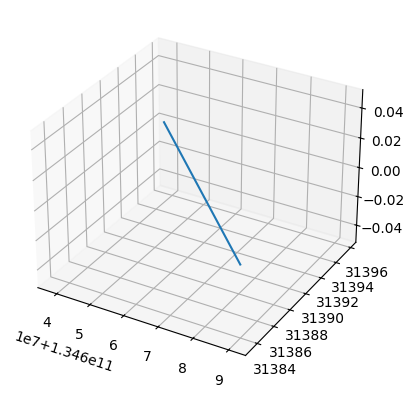

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
plt.show()